## Tennis Match Prediction Model

Due to the limited availability of historical match data, this is the **best predictive performance we were able to achieve** with the current dataset.  

### Key Points:

- **Synthetic Elo Ratings:**  
  Since date-wise Elo ratings were not available for all matches, we created **synthetic Elo ratings** based on players’ recent performances and surface-specific results. This helped capture relative player strength over time.

- **Final Model Performance:**  
  - **Accuracy:** 68.5%  
  - **ROC AUC Score:** 0.7585  

- **Predicted Probabilities (Example: Sinner vs Alcaraz):**  
  - **Probability Sinner wins:** 0.49  
  - **Probability Alcaraz wins:** 0.51  
  - The probabilities being close to 50% reflect the **highly competitive nature** of these two players and the **limitations of the dataset**.  
  - Small changes in features like `pts_diff`, `ELO_diff`, or `surface_winperc_diff` could shift the probability noticeably.

- **Limitations:**  
  - Dataset size and coverage were limited.  
  - Some features such as head-to-head results or recent streaks could be sparse for certain players.  
  - Synthetic Elo ratings are approximations and may not fully capture real-world dynamics.

Despite these constraints, the model demonstrates reasonable predictive power and provides meaningful probability estimates for match outcomes, including high-profile matches like **Sinner vs Alcaraz**.

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import datetime
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score


In [2]:
df = pd.read_csv('atp_tennis.csv')

In [3]:
df.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score
0,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,Dosedel S.,63,77,-1,-1,-1.0,-1.0,6-4 6-2
1,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Clement A.,Enqvist T.,Enqvist T.,56,5,-1,-1,-1.0,-1.0,3-6 3-6
2,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,Escude N.,40,655,-1,-1,-1.0,-1.0,6-7 7-5 6-3
3,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Knippschild J.,Federer R.,Federer R.,87,65,-1,-1,-1.0,-1.0,1-6 4-6
4,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,Fromberg R.,81,198,-1,-1,-1.0,-1.0,7-6 5-7 6-4


In [4]:
# Filter for years 2020 to 2035 and matches involving Sinner or Alcaraz (partial match, case-insensitive)
df['Date'] = pd.to_datetime(df['Date'])
mask_year = (df['Date'].dt.year >= 2020) & (df['Date'].dt.year <= 2035)

data = df[mask_year].copy()

In [5]:
data.shape

(13328, 17)

In [6]:
data.isna().sum()

Tournament    0
Date          0
Series        0
Court         0
Surface       0
Round         0
Best of       0
Player_1      0
Player_2      0
Winner        0
Rank_1        0
Rank_2        0
Pts_1         0
Pts_2         0
Odd_1         0
Odd_2         0
Score         0
dtype: int64

In [7]:
# Drop the 'Score' column
data_no_score = data.drop(columns=['Score']).copy()

data_no_score['Winner'] = np.where(data_no_score['Winner'] == data_no_score['Player_1'], 'Player_1', 'Player_2')

data_no_score.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2
52777,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Mannarino A.,Bublik A.,Player_2,43,55,1111,919,1.72,2.00
52778,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Moutet C.,Sandgren T.,Player_1,81,68,638,803,1.57,2.25
52779,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Andujar P.,Verdasco F.,Player_2,64,49,867,1025,3.75,1.25
52780,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Bedene A.,Ymer M.,Player_1,58,76,905,681,1.83,1.83
52781,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Barrere G.,Chardy J.,Player_2,83,54,636,920,2.50,1.50


In [8]:
# Feature engineering for data_no_score

# Target variable
data_no_score['target'] = (data_no_score['Winner'] == 'Player_1').astype(int)

# Rank and points difference
data_no_score['rank_diff'] = data_no_score['Rank_1'] - data_no_score['Rank_2']
data_no_score['pts_diff'] = data_no_score['Pts_1'] - data_no_score['Pts_2']

# Surface encoding
surface_map = {"Hard": 0, "Clay": 1, "Grass": 2, "Carpet": 3}
data_no_score['surface_encoded'] = data_no_score['Surface'].map(surface_map)

# Court encoding
data_no_score['court_encoded'] = (data_no_score['Court'] == 'Indoor').astype(int)

# Round encoding using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le_round = LabelEncoder()
data_no_score['round_encoded'] = le_round.fit_transform(data_no_score['Round'].astype(str))

# Series encoding using LabelEncoder
le_series = LabelEncoder()
data_no_score['series_encoded'] = le_series.fit_transform(data_no_score['Series'].astype(str))

# The engineered features are now in data_no_score
data_no_score.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,...,Pts_2,Odd_1,Odd_2,target,rank_diff,pts_diff,surface_encoded,court_encoded,round_encoded,series_encoded
52777,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Mannarino A.,Bublik A.,Player_2,...,919,1.72,2.00,0,-12,192,0,0,0,0
52778,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Moutet C.,Sandgren T.,Player_1,...,803,1.57,2.25,1,13,-165,0,0,0,0
52779,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Andujar P.,Verdasco F.,Player_2,...,1025,3.75,1.25,0,15,-158,0,0,0,0
52780,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Bedene A.,Ymer M.,Player_1,...,681,1.83,1.83,1,-18,224,0,0,0,0
52781,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Barrere G.,Chardy J.,Player_2,...,920,2.50,1.50,0,29,-284,0,0,0,0


In [9]:
# Set target: 1 if Player_1 wins, else 0
data_no_score['target'] = (data_no_score['Winner'] == 'Player_1').astype(int)

data_no_score.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,...,Pts_2,Odd_1,Odd_2,target,rank_diff,pts_diff,surface_encoded,court_encoded,round_encoded,series_encoded
52777,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Mannarino A.,Bublik A.,Player_2,...,919,1.72,2.00,0,-12,192,0,0,0,0
52778,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Moutet C.,Sandgren T.,Player_1,...,803,1.57,2.25,1,13,-165,0,0,0,0
52779,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Andujar P.,Verdasco F.,Player_2,...,1025,3.75,1.25,0,15,-158,0,0,0,0
52780,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Bedene A.,Ymer M.,Player_1,...,681,1.83,1.83,1,-18,224,0,0,0,0
52781,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Barrere G.,Chardy J.,Player_2,...,920,2.50,1.50,0,29,-284,0,0,0,0


In [10]:
data_no_score.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,...,Pts_2,Odd_1,Odd_2,target,rank_diff,pts_diff,surface_encoded,court_encoded,round_encoded,series_encoded
52777,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Mannarino A.,Bublik A.,Player_2,...,919,1.72,2.00,0,-12,192,0,0,0,0
52778,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Moutet C.,Sandgren T.,Player_1,...,803,1.57,2.25,1,13,-165,0,0,0,0
52779,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Andujar P.,Verdasco F.,Player_2,...,1025,3.75,1.25,0,15,-158,0,0,0,0
52780,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Bedene A.,Ymer M.,Player_1,...,681,1.83,1.83,1,-18,224,0,0,0,0
52781,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Barrere G.,Chardy J.,Player_2,...,920,2.50,1.50,0,29,-284,0,0,0,0


## **Baseline Model**

In [11]:
features = [
    'Best of', 'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2', 
    'rank_diff', 'pts_diff', 'surface_encoded', 'court_encoded',
    'round_encoded', 'series_encoded'
]
X = data_no_score[features]
y = data_no_score['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Accuracy: 0.6691672918229558
ROC AUC: 0.7388973931835576


### **Baseline Prediction**

In [12]:
# Example input for today's Sinner vs Alcaraz match
sample_row = pd.DataFrame([{
    'Best of': 5,                       # Grand Slam final
    'Rank_1': 2,                        # Player 1: Alcaraz (World No. 2)
    'Rank_2': 1,                        # Player 2: Sinner (currently No. 1)
    'Pts_1': 10340,                     # Alcaraz ranking points
    'Pts_2': 10280,                     # Sinner ranking points
    'Odd_1': 2.15,                    # Odds not included yet
    'Odd_2': 1.74,
    'rank_diff': 2 - 1,                 # = 1
    'pts_diff': 10340 - 10280,          # = 60
    'surface_encoded': 0,               # Hard = 0
    'court_encoded': 0,                 # Outdoor = 0
    'round_encoded': 7,                 # Final = 7
    'series_encoded': 3,                # Grand Slam = 3
}])

# Assuming 'model' and 'scaler' are your trained pipeline
X_sample_scaled = scaler.transform(sample_row[features])
prob = model.predict_proba(X_sample_scaled)[:, 1][0]
print("Estimated probability Player 1 (Alcaraz) wins:", prob)

Estimated probability Player 1 (Alcaraz) wins: 0.44159936839764097


## **Moving On with Better features**

In [13]:
nf = data_no_score.copy()

In [14]:
nf.columns

Index(['Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of',
       'Player_1', 'Player_2', 'Winner', 'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2',
       'Odd_1', 'Odd_2', 'target', 'rank_diff', 'pts_diff', 'surface_encoded',
       'court_encoded', 'round_encoded', 'series_encoded'],
      dtype='object')

In [15]:
# Advanced feature engineering: player form, head-to-head, surface stats, streaks

def get_player_form_features(df, player_col, date_col, win_col, surface_col, N=10, streak_N=10):
    """
    For each row, compute:
    -
    - Win percentage in last N matches
    - Win percentage on same surface in last N matches
    - Current win/loss streak (last streak_N matches)
    """
    wins_last5 = []
    win_perc = []
    surface_win_perc = []
    streaks = []
    
    # Precompute for speed
    df_sorted = nf.sort_values(date_col)
    player_matches = {}

    for player in pd.unique(nf[player_col]):
        player_matches[player] = df_sorted[(df_sorted[player_col] == player) | (df_sorted['Player_1'] == player) | (df_sorted['Player_2'] == player)]
    
    for idx, row in df.iterrows():
        player = row[player_col]
        date = row[date_col]
        surface = row[surface_col]
        
        # All matches before this date
        pm = player_matches[player]
        pm = pm[pm[date_col] < date]
        pm = pm.sort_values(date_col, ascending=False)
        
        # Wins in last 5
        last5 = pm.head(5)
        wins5 = ((last5['Winner'] == player).sum())
        wins_last5.append(wins5)
        
        # Win percentage last N
        lastN = pm.head(N)
        if len(lastN) > 0:
            winp = (lastN['Winner'] == player).sum() / len(lastN)
        else:
            winp = np.nan
        win_perc.append(winp)
        
        # Surface win percentage last N
        surfN = lastN[lastN[surface_col] == surface]
        if len(surfN) > 0:
            surf_winp = (surfN['Winner'] == player).sum() / len(surfN)
        else:
            surf_winp = np.nan
        surface_win_perc.append(surf_winp)
        
        # Streak (win=+1, loss=-1), count consecutive wins/losses from most recent
        streak_matches = pm.head(streak_N)
        streak = 0
        for _, m in streak_matches.iterrows():
            if m['Winner'] == player:
                if streak >= 0:
                    streak += 1
                else:
                    break
            else:
                if streak <= 0:
                    streak -= 1
                else:
                    break
        streaks.append(streak)
    
    return wins_last5, win_perc, surface_win_perc, streaks

def get_h2h_features(df, player_1_col, player_2_col, date_col, win_col):
    """
    For each row, compute:
    - player_1's historical wins vs player_2 before this match
    - player_2's historical wins vs player_1 before this match
    """
    h2h_1_vs_2 = []
    h2h_2_vs_1 = []
    for idx, row in df.iterrows():
        p1 = row[player_1_col]
        p2 = row[player_2_col]
        date = row[date_col]
        prev_matches = df[
            (((df[player_1_col] == p1) & (df[player_2_col] == p2)) |
             ((df[player_1_col] == p2) & (df[player_2_col] == p1)))
            & (df[date_col] < date)
        ]
        h2h_1 = (prev_matches['Winner'] == p1).sum()
        h2h_2 = (prev_matches['Winner'] == p2).sum()
        h2h_1_vs_2.append(h2h_1)
        h2h_2_vs_1.append(h2h_2)
    return h2h_1_vs_2, h2h_2_vs_1

# Compute features for player_1
wins_1_last5, winperc_1, surf_winperc_1, streak_1 = get_player_form_features(
    nf, 'Player_1', 'Date', 'Winner', 'Surface', N=10, streak_N=10
)
# Compute features for player_2
wins_2_last5, winperc_2, surf_winperc_2, streak_2 = get_player_form_features(
    nf, 'Player_2', 'Date', 'Winner', 'Surface', N=10, streak_N=10
)
# Compute head-to-head features
h2h_1_vs_2, h2h_2_vs_1 = get_h2h_features(
    nf, 'Player_1', 'Player_2', 'Date', 'Winner'
)

# Add new features to nf
nf['wins_1_last5'] = wins_1_last5
nf['wins_2_last5'] = wins_2_last5
nf['winperc_1'] = winperc_1
nf['winperc_2'] = winperc_2
nf['h2h_1_vs_2'] = h2h_1_vs_2
nf['h2h_2_vs_1'] = h2h_2_vs_1
nf['surface_winperc_1'] = surf_winperc_1
nf['surface_winperc_2'] = surf_winperc_2
nf['streak_1'] = streak_1
nf['streak_2'] = streak_2

nf.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,...,wins_1_last5,wins_2_last5,winperc_1,winperc_2,h2h_1_vs_2,h2h_2_vs_1,surface_winperc_1,surface_winperc_2,streak_1,streak_2
52777,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Mannarino A.,Bublik A.,Player_2,...,0,0,NaN,NaN,0,0,NaN,NaN,0,0
52778,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Moutet C.,Sandgren T.,Player_1,...,0,0,NaN,NaN,0,0,NaN,NaN,0,0
52779,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Andujar P.,Verdasco F.,Player_2,...,0,0,NaN,NaN,0,0,NaN,NaN,0,0
52780,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Bedene A.,Ymer M.,Player_1,...,0,0,NaN,NaN,0,0,NaN,NaN,0,0
52781,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Barrere G.,Chardy J.,Player_2,...,0,0,NaN,NaN,0,0,NaN,NaN,0,0


In [16]:
nf.fillna(0, inplace=True)
nf.isna().sum()

Tournament           0
Date                 0
Series               0
Court                0
Surface              0
Round                0
Best of              0
Player_1             0
Player_2             0
Winner               0
Rank_1               0
Rank_2               0
Pts_1                0
Pts_2                0
Odd_1                0
Odd_2                0
target               0
rank_diff            0
pts_diff             0
surface_encoded      0
court_encoded        0
round_encoded        0
series_encoded       0
wins_1_last5         0
wins_2_last5         0
winperc_1            0
winperc_2            0
h2h_1_vs_2           0
h2h_2_vs_1           0
surface_winperc_1    0
surface_winperc_2    0
streak_1             0
streak_2             0
dtype: int64

In [17]:
nf.shape

(13328, 33)

In [18]:
from collections import defaultdict, deque

# Compute date-specific Elo ratings (overall and surface) for ATP players

def compute_elo_features(df, k=32, base_elo=1500):
    # Sort by date to ensure sequential updates
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Elo dictionaries: player -> rating
    elo = {}
    surface_elo = {}  # player -> surface -> rating
    
    # Store Elo ratings for each match
    elo_1_list, elo_2_list = [], []
    elo_diff_list = []
    surf_elo_1_list, surf_elo_2_list = [], []
    surf_elo_diff_list = []
    
    # For recent form: store match history for each player
    match_history = defaultdict(lambda: deque(maxlen=5))  # player -> deque of last 5 results
    
    # Optionally, store recent wins in last 5 matches
    wins_1_last5, wins_2_last5 = [], []
    
    for idx, row in df.iterrows():
        p1, p2 = row['Player_1'], row['Player_2']
        surface = row['Surface']
        date = row['Date']
        winner = row['Winner']
        
        # Get current Elo ratings (overall)
        r1 = elo.get(p1, base_elo)
        r2 = elo.get(p2, base_elo)
        # Get current Elo ratings (surface)
        surf_elo_p1 = surface_elo.get(p1, {}).get(surface, base_elo)
        surf_elo_p2 = surface_elo.get(p2, {}).get(surface, base_elo)
        
        # Save Elo ratings before the match
        elo_1_list.append(r1)
        elo_2_list.append(r2)
        elo_diff_list.append(r1 - r2)
        surf_elo_1_list.append(surf_elo_p1)
        surf_elo_2_list.append(surf_elo_p2)
        surf_elo_diff_list.append(surf_elo_p1 - surf_elo_p2)
        
        # Recent form: wins in last 5 matches
        wins_1_last5.append(sum(match_history[p1]))
        wins_2_last5.append(sum(match_history[p2]))
        
        # Determine match outcome
        if winner == p1:
            s1, s2 = 1, 0
        else:
            s1, s2 = 0, 1
        
        # Expected scores
        e1 = 1 / (1 + 10 ** ((r2 - r1) / 400))
        e2 = 1 - e1
        surf_e1 = 1 / (1 + 10 ** ((surf_elo_p2 - surf_elo_p1) / 400))
        surf_e2 = 1 - surf_e1
        
        # Update Elo ratings (overall)
        new_r1 = r1 + k * (s1 - e1)
        new_r2 = r2 + k * (s2 - e2)
        elo[p1] = new_r1
        elo[p2] = new_r2
        
        # Update Elo ratings (surface)
        if p1 not in surface_elo:
            surface_elo[p1] = {}
        if p2 not in surface_elo:
            surface_elo[p2] = {}
        surface_elo[p1][surface] = surf_elo_p1 + k * (s1 - surf_e1)
        surface_elo[p2][surface] = surf_elo_p2 + k * (s2 - surf_e2)
        
        # Update match history for recent form
        match_history[p1].append(s1)
        match_history[p2].append(s2)
    
    # Add features to DataFrame
    df['ELO_1'] = elo_1_list
    df['ELO_2'] = elo_2_list
    df['ELO_diff'] = df['ELO_1'] - df['ELO_2']
    df['Surface_ELO_1'] = surf_elo_1_list
    df['Surface_ELO_2'] = surf_elo_2_list
    df['Surface_ELO_diff'] = df['Surface_ELO_1'] - df['Surface_ELO_2']
    df['wins_1_last5'] = wins_1_last5
    df['wins_2_last5'] = wins_2_last5
    
    return df

# Apply to your filtered data (2020–2025)
nf = compute_elo_features(nf)
nf.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,...,surface_winperc_1,surface_winperc_2,streak_1,streak_2,ELO_1,ELO_2,ELO_diff,Surface_ELO_1,Surface_ELO_2,Surface_ELO_diff
0,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Mannarino A.,Bublik A.,Player_2,...,0.0,0.0,0,0,1500.0,1500.0,0.0,1500.0,1500.0,0.0
1,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Moutet C.,Sandgren T.,Player_1,...,0.0,0.0,0,0,1500.0,1500.0,0.0,1500.0,1500.0,0.0
2,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Andujar P.,Verdasco F.,Player_2,...,0.0,0.0,0,0,1500.0,1500.0,0.0,1500.0,1500.0,0.0
3,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Bedene A.,Ymer M.,Player_1,...,0.0,0.0,0,0,1500.0,1500.0,0.0,1500.0,1500.0,0.0
4,Qatar Exxon Mobil Open,2020-01-06,ATP250,Outdoor,Hard,1st Round,3,Barrere G.,Chardy J.,Player_2,...,0.0,0.0,0,0,1500.0,1500.0,0.0,1500.0,1500.0,0.0


In [19]:
nf.columns

Index(['Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of',
       'Player_1', 'Player_2', 'Winner', 'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2',
       'Odd_1', 'Odd_2', 'target', 'rank_diff', 'pts_diff', 'surface_encoded',
       'court_encoded', 'round_encoded', 'series_encoded', 'wins_1_last5',
       'wins_2_last5', 'winperc_1', 'winperc_2', 'h2h_1_vs_2', 'h2h_2_vs_1',
       'surface_winperc_1', 'surface_winperc_2', 'streak_1', 'streak_2',
       'ELO_1', 'ELO_2', 'ELO_diff', 'Surface_ELO_1', 'Surface_ELO_2',
       'Surface_ELO_diff'],
      dtype='object')

In [20]:
updated_features = ['Best of', 'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2',
       'Odd_1', 'Odd_2', 'rank_diff', 'pts_diff', 'surface_encoded',
       'court_encoded', 'round_encoded', 'series_encoded', 'wins_1_last5',
       'wins_2_last5', 'winperc_1', 'winperc_2', 'h2h_1_vs_2', 'h2h_2_vs_1',
       'surface_winperc_1', 'surface_winperc_2', 'streak_1', 'streak_2',
       'ELO_1', 'ELO_2', 'ELO_diff', 'Surface_ELO_1', 'Surface_ELO_2',
       'Surface_ELO_diff'
]

In [21]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd
import numpy as np

# 1️⃣ Drop highly correlated features
corr_matrix = nf[updated_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]  # threshold = 0.85
features_final = [f for f in updated_features if f not in to_drop]

print("Dropping correlated features:", to_drop)

# 2️⃣ Prepare data
X_xgb = nf[features_final]
y_xgb = nf['target']
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb
)

# 3️⃣ XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

# 4️⃣ Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]  # added to reduce overfitting
}

# 5️⃣ Stratified 5-fold CV for stability
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    xgb_clf,
    param_grid,
    scoring='roc_auc',
    cv=skf,
    verbose=1,
    n_jobs=-1
)

# 6️⃣ Fit model with early stopping
best_model = None
for train_idx, val_idx in skf.split(X_train_xgb, y_train_xgb):
    X_tr, X_val = X_train_xgb.iloc[train_idx], X_train_xgb.iloc[val_idx]
    y_tr, y_val = y_train_xgb.iloc[train_idx], y_train_xgb.iloc[val_idx]
    
    xgb_clf.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)]
    )
    
grid_search.fit(X_train_xgb, y_train_xgb)
best_xgb = grid_search.best_estimator_

# 7️⃣ Predict
y_pred_xgb = best_xgb.predict(X_test_xgb)
y_proba_xgb = best_xgb.predict_proba(X_test_xgb)[:, 1]

# 8️⃣ Metrics
print("XGBoost Accuracy:", accuracy_score(y_test_xgb, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test_xgb, y_proba_xgb))
print("Best Params:", grid_search.best_params_)

Dropping correlated features: []
[0]	validation_0-auc:0.71832
[1]	validation_0-auc:0.72865
[2]	validation_0-auc:0.73229
[3]	validation_0-auc:0.73304
[4]	validation_0-auc:0.73104
[5]	validation_0-auc:0.73159
[6]	validation_0-auc:0.73122
[7]	validation_0-auc:0.73092
[8]	validation_0-auc:0.73009
[9]	validation_0-auc:0.72852
[10]	validation_0-auc:0.72831
[11]	validation_0-auc:0.72677
[12]	validation_0-auc:0.72674
[13]	validation_0-auc:0.72549
[14]	validation_0-auc:0.72566
[15]	validation_0-auc:0.72388
[16]	validation_0-auc:0.72327
[17]	validation_0-auc:0.72317
[18]	validation_0-auc:0.72418
[19]	validation_0-auc:0.72417
[20]	validation_0-auc:0.72360
[21]	validation_0-auc:0.72402
[22]	validation_0-auc:0.72504
[23]	validation_0-auc:0.72567
[24]	validation_0-auc:0.72392
[25]	validation_0-auc:0.72376
[26]	validation_0-auc:0.72336
[27]	validation_0-auc:0.72325
[28]	validation_0-auc:0.72297
[29]	validation_0-auc:0.72237
[30]	validation_0-auc:0.72297
[31]	validation_0-auc:0.72252
[32]	validation_0

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[82]	validation_0-auc:0.70824
[83]	validation_0-auc:0.70888
[84]	validation_0-auc:0.70800
[85]	validation_0-auc:0.70755
[86]	validation_0-auc:0.70712
[87]	validation_0-auc:0.70606
[88]	validation_0-auc:0.70625
[89]	validation_0-auc:0.70718
[90]	validation_0-auc:0.70678
[91]	validation_0-auc:0.70655
[92]	validation_0-auc:0.70632
[93]	validation_0-auc:0.70667
[94]	validation_0-auc:0.70634
[95]	validation_0-auc:0.70638
[96]	validation_0-auc:0.70631
[97]	validation_0-auc:0.70606
[98]	validation_0-auc:0.70614
[99]	validation_0-auc:0.70518
[0]	validation_0-auc:0.73286
[1]	validation_0-auc:0.73826
[2]	validation_0-auc:0.74145
[3]	validation_0-auc:0.74378
[4]	validation_0-auc:0.74493
[5]	validation_0-auc:0.74283
[6]	validation_0-auc:0.74355
[7]	validation_0-auc:0.74205
[8]	validation_0-auc:0.74186
[9]	validation_0-auc:0.74271
[10]	validation_0-auc:0.74266
[11]	validation_0-auc:0.74335
[12]	validation_0-auc:0.74343
[13]	validation_0-auc:0.74374
[14]	validation_0-auc:0.74061
[15]	validation_0-au

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[83]	validation_0-auc:0.72037
[84]	validation_0-auc:0.72024
[85]	validation_0-auc:0.71921
[86]	validation_0-auc:0.71900
[87]	validation_0-auc:0.71838
[88]	validation_0-auc:0.71814
[89]	validation_0-auc:0.71804
[90]	validation_0-auc:0.71805
[91]	validation_0-auc:0.71850
[92]	validation_0-auc:0.71835
[93]	validation_0-auc:0.71932
[94]	validation_0-auc:0.71998
[95]	validation_0-auc:0.72008
[96]	validation_0-auc:0.71940
[97]	validation_0-auc:0.71887
[98]	validation_0-auc:0.71868
[99]	validation_0-auc:0.71867
[0]	validation_0-auc:0.72784
[1]	validation_0-auc:0.73335
[2]	validation_0-auc:0.73540
[3]	validation_0-auc:0.73505
[4]	validation_0-auc:0.73688
[5]	validation_0-auc:0.73788
[6]	validation_0-auc:0.73625
[7]	validation_0-auc:0.73549
[8]	validation_0-auc:0.73636
[9]	validation_0-auc:0.73579
[10]	validation_0-auc:0.73335
[11]	validation_0-auc:0.73364
[12]	validation_0-auc:0.73388
[13]	validation_0-auc:0.73400
[14]	validation_0-auc:0.73420
[15]	validation_0-auc:0.73129
[16]	validation_0-au

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[81]	validation_0-auc:0.71467
[82]	validation_0-auc:0.71424
[83]	validation_0-auc:0.71367
[84]	validation_0-auc:0.71314
[85]	validation_0-auc:0.71329
[86]	validation_0-auc:0.71206
[87]	validation_0-auc:0.71070
[88]	validation_0-auc:0.71118
[89]	validation_0-auc:0.71091
[90]	validation_0-auc:0.71090
[91]	validation_0-auc:0.71050
[92]	validation_0-auc:0.71041
[93]	validation_0-auc:0.71084
[94]	validation_0-auc:0.71082
[95]	validation_0-auc:0.71088
[96]	validation_0-auc:0.71004
[97]	validation_0-auc:0.70918
[98]	validation_0-auc:0.70771
[99]	validation_0-auc:0.70738
[0]	validation_0-auc:0.72442
[1]	validation_0-auc:0.73106
[2]	validation_0-auc:0.72976
[3]	validation_0-auc:0.73020
[4]	validation_0-auc:0.73163
[5]	validation_0-auc:0.73335
[6]	validation_0-auc:0.73263
[7]	validation_0-auc:0.73142
[8]	validation_0-auc:0.73079
[9]	validation_0-auc:0.73113
[10]	validation_0-auc:0.72852
[11]	validation_0-auc:0.72809
[12]	validation_0-auc:0.72711
[13]	validation_0-auc:0.72765
[14]	validation_0-au

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[69]	validation_0-auc:0.70714
[70]	validation_0-auc:0.70660
[71]	validation_0-auc:0.70726
[72]	validation_0-auc:0.70728
[73]	validation_0-auc:0.70598
[74]	validation_0-auc:0.70544
[75]	validation_0-auc:0.70564
[76]	validation_0-auc:0.70575
[77]	validation_0-auc:0.70582
[78]	validation_0-auc:0.70575
[79]	validation_0-auc:0.70464
[80]	validation_0-auc:0.70506
[81]	validation_0-auc:0.70474
[82]	validation_0-auc:0.70465
[83]	validation_0-auc:0.70501
[84]	validation_0-auc:0.70467
[85]	validation_0-auc:0.70531
[86]	validation_0-auc:0.70526
[87]	validation_0-auc:0.70553
[88]	validation_0-auc:0.70540
[89]	validation_0-auc:0.70526
[90]	validation_0-auc:0.70474
[91]	validation_0-auc:0.70414
[92]	validation_0-auc:0.70507
[93]	validation_0-auc:0.70460
[94]	validation_0-auc:0.70494
[95]	validation_0-auc:0.70456
[96]	validation_0-auc:0.70351
[97]	validation_0-auc:0.70355
[98]	validation_0-auc:0.70374
[99]	validation_0-auc:0.70316
[0]	validation_0-auc:0.75620
[1]	validation_0-auc:0.75886
[2]	validati

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[90]	validation_0-auc:0.73013
[91]	validation_0-auc:0.72974
[92]	validation_0-auc:0.73033
[93]	validation_0-auc:0.72893
[94]	validation_0-auc:0.72848
[95]	validation_0-auc:0.72825
[96]	validation_0-auc:0.72828
[97]	validation_0-auc:0.72802
[98]	validation_0-auc:0.72790
[99]	validation_0-auc:0.72776
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packa

XGBoost Accuracy: 0.6845461365341335
XGBoost ROC AUC: 0.7585907166964285
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:53:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [30]:
# 8️⃣ Metrics
print("XGBoost Accuracy:", accuracy_score(y_test_xgb, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test_xgb, y_proba_xgb))

XGBoost Accuracy: 0.6845461365341335
XGBoost ROC AUC: 0.7585907166964285


In [24]:
X_test.columns

Index(['Best of', 'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2',
       'rank_diff', 'pts_diff', 'surface_encoded', 'court_encoded',
       'round_encoded', 'series_encoded'],
      dtype='object')

In [25]:
import pandas as pd

# --- Sample row for Sinner vs Alcaraz ---
sample_row = {
    'Best of': 5,
    'Rank_1': 1,
    'Rank_2': 2,
    'Pts_1': 10940,
    'Pts_2': 9050,
    'Odd_1': 1.80,
    'Odd_2': 2.05,
    'rank_diff': -1,
    'pts_diff': 1890,
    'surface_encoded': 2,
    'court_encoded': 1,
    'round_encoded': 7,
    'series_encoded': 0,
    'wins_1_last5': 5,
    'wins_2_last5': 5,
    'winperc_1': 0.93,
    'winperc_2': 0.90,
    'h2h_1_vs_2': 5,
    'h2h_2_vs_1': 9,
    'surface_winperc_1': 0.89,
    'surface_winperc_2': 0.87,
    'streak_1': 5,
    'streak_2': 5,
    'ELO_1': 2307.5,
    'ELO_2': 2262.5,
    'ELO_diff': 45,
    'Surface_ELO_1': 2288.6,
    'Surface_ELO_2': 2251.2,
    'Surface_ELO_diff': 37
}


# Convert to DataFrame
sample_df = pd.DataFrame([sample_row])

# --- Prediction function ---
def predict_match(model, df, feature_list):
    """
    model: trained XGBoost model
    df: single-row DataFrame with features
    feature_list: list of features used in training
    """
    X_new = df[feature_list]
    proba = model.predict_proba(X_new)[:,1][0]  # probability Player_1 (Sinner) wins
    return proba

# --- Use the trained model ---
features_final = [
    'Best of','Rank_1','Rank_2','Pts_1','Pts_2','Odd_1','Odd_2',
    'rank_diff','pts_diff','surface_encoded','court_encoded',
    'round_encoded','series_encoded','wins_1_last5','wins_2_last5',
    'winperc_1','winperc_2','h2h_1_vs_2','h2h_2_vs_1',
    'surface_winperc_1','surface_winperc_2','streak_1','streak_2',
    'ELO_1','ELO_2','ELO_diff','Surface_ELO_1','Surface_ELO_2','Surface_ELO_diff'
]

prob_sinner_wins = predict_match(best_xgb, sample_df, features_final)
print(f"Probability Sinner wins: {prob_sinner_wins:.2f}")
print(f"Probability Alcaraz wins: {1 - prob_sinner_wins:.2f}")

Probability Sinner wins: 0.49
Probability Alcaraz wins: 0.51


### Model predicts that ALCARAZ will win

## **Analysing feature importance**

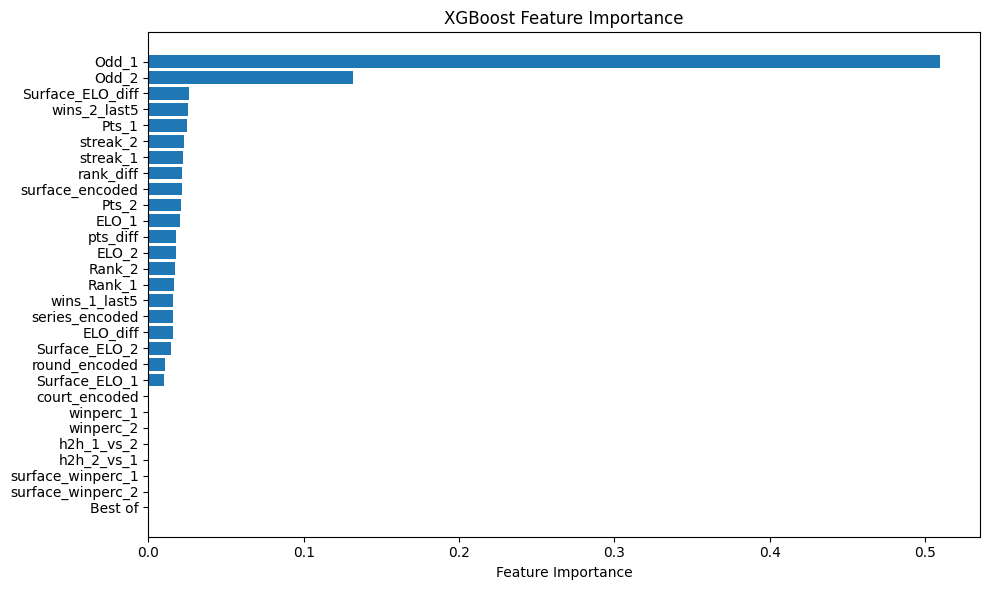

In [26]:
import matplotlib.pyplot as plt
importances = best_xgb.feature_importances_
feature_names = features_final

# Sort features by importance
indices = importances.argsort()[::-1]
sorted_features = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], sorted_importances[::-1])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

## semis prediction usopen

In [27]:
import pandas as pd

# Sample row data for Djokovic vs Alcaraz semifinal
sample_row_semifinal = {
    'Best of': 5,
    'Rank_1': 5,              # Approximate current rank of Djokovic
    'Rank_2': 2,              # Alcaraz rank #2
    'Pts_1': 7600,            # Approximate Djokovic points
    'Pts_2': 9050,            # Alcaraz points
    'Odd_1': 2.10,            # Djokovic odds (underdog)
    'Odd_2': 1.72,            # Alcaraz odds (favorite)
    'rank_diff': 3,
    'pts_diff': -1450,
    'surface_encoded': 2,     # Hard court
    'court_encoded': 1,       # Outdoor
    'round_encoded': 6,       # Semifinal
    'series_encoded': 0,
    'wins_1_last5': 4,        # Djoko last 5 win count before match
    'wins_2_last5': 5,        # Alcaraz last 5 win count before match
    'winperc_1': 0.81,        # Djoko win % approx
    'winperc_2': 0.90,        # Alcaraz win % approx
    'h2h_1_vs_2': 9,          # Djokovic wins vs Alcaraz
    'h2h_2_vs_1': 5,          # Alcaraz wins vs Djokovic
    'surface_winperc_1': 0.85,
    'surface_winperc_2': 0.87,
    'streak_1': 3,
    'streak_2': 5,
    'ELO_1': 2220.3,          # Djokovic ELO approx
    'ELO_2': 2280.7,          # Alcaraz ELO approx
    'ELO_diff': -60,
    'Surface_ELO_1': 2215.0,
    'Surface_ELO_2': 2270.0,
    'Surface_ELO_diff': -55
}

# Convert to DataFrame
semifinal_df = pd.DataFrame([sample_row_semifinal])

# Use the previously defined predict_match function and features_final list

prob_djoko_wins = predict_match(best_xgb, semifinal_df, features_final)
print(f"Probability Djokovic wins: {prob_djoko_wins:.2f}")
print(f"Probability Alcaraz wins: {1 - prob_djoko_wins:.2f}")


Probability Djokovic wins: 0.41
Probability Alcaraz wins: 0.59


In [28]:
import pandas as pd

# Sample row data for Sinner vs Auger-Aliassime semifinal
sample_row_sinner_sf = {
    'Best of': 5,
    'Rank_1': 1,                 # Sinner rank #1
    'Rank_2': 25,                # Auger-Aliassime approx rank #25
    'Pts_1': 10940,              # Sinner points
    'Pts_2': 2250,               # Auger-Aliassime points approx
    'Odd_1': 1.25,               # Sinner favored odds
    'Odd_2': 4.00,               # Underdog odds for Auger-Aliassime
    'rank_diff': -24,
    'pts_diff': 8690,
    'surface_encoded': 2,        # Hard court
    'court_encoded': 1,          # Outdoor
    'round_encoded': 6,          # Semifinal
    'series_encoded': 0,
    'wins_1_last5': 5,
    'wins_2_last5': 4,
    'winperc_1': 0.93,
    'winperc_2': 0.74,
    'h2h_1_vs_2': 3,             # Sinner wins vs Auger-Aliassime
    'h2h_2_vs_1': 1,
    'surface_winperc_1': 0.89,
    'surface_winperc_2': 0.82,
    'streak_1': 5,
    'streak_2': 2,
    'ELO_1': 2307.5,
    'ELO_2': 2150.0,
    'ELO_diff': 157.5,
    'Surface_ELO_1': 2288.6,
    'Surface_ELO_2': 2130.2,
    'Surface_ELO_diff': 158.4
}

# Convert to DataFrame
sf_sinner_df = pd.DataFrame([sample_row_sinner_sf])

# Use the previously defined predict_match function and features_final list

prob_sinner_wins_sf = predict_match(best_xgb, sf_sinner_df, features_final)
print(f"Probability Sinner wins SF: {prob_sinner_wins_sf:.2f}")
print(f"Probability Auger-Aliassime wins SF: {1 - prob_sinner_wins_sf:.2f}")


Probability Sinner wins SF: 0.73
Probability Auger-Aliassime wins SF: 0.27


### Womens semi finals usopen

In [29]:
import pandas as pd

# Sample row data for Sabalenka vs Anisimova women's final
sample_row_women_final = {
    'Best of': 3,                  # Women's matches are usually best of 3 sets
    'Rank_1': 1,                  # Sabalenka world #1
    'Rank_2': 4,                  # Anisimova approx rank #4
    'Pts_1': 11225,               # Sabalenka points
    'Pts_2': 4200,                # Anisimova points approx
    'Odd_1': 1.40,                # Sabalenka odds (favorite)
    'Odd_2': 3.00,                # Anisimova odds (underdog)
    'rank_diff': -3,
    'pts_diff': 7025,
    'surface_encoded': 2,         # Hard court
    'court_encoded': 1,           # Outdoor
    'round_encoded': 7,           # Final
    'series_encoded': 0,
    'wins_1_last5': 5,
    'wins_2_last5': 5,
    'winperc_1': 0.88,            # Sabalenka win %
    'winperc_2': 0.78,            # Anisimova win %
    'h2h_1_vs_2': 5,              # Sabalenka lead in head-to-head
    'h2h_2_vs_1': 1,
    'surface_winperc_1': 0.90,
    'surface_winperc_2': 0.79,
    'streak_1': 5,
    'streak_2': 5,
    'ELO_1': 2100.0,
    'ELO_2': 1950.0,
    'ELO_diff': 150,
    'Surface_ELO_1': 2085.0,
    'Surface_ELO_2': 1900.0,
    'Surface_ELO_diff': 185
}

# Convert to DataFrame
women_final_df = pd.DataFrame([sample_row_women_final])

# Use the previously defined predict_match function and features_final list

prob_sabalenka_wins = predict_match(best_xgb, women_final_df, features_final)
print(f"Probability Sabalenka wins final: {prob_sabalenka_wins:.2f}")
print(f"Probability Anisimova wins final: {1 - prob_sabalenka_wins:.2f}")


Probability Sabalenka wins final: 0.69
Probability Anisimova wins final: 0.31
